In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
from sklearn.decomposition import PCA

In [2]:
def basemap_base(name_projection,axes,lat,lon,latS,latN,lonL,lonR):
    m = Basemap(projection=name_projection,
                llcrnrlat=latS,urcrnrlat=latN,\
                llcrnrlon=lonL,urcrnrlon=lonR,resolution='l',ax=axes)

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2,lat2)

    m.fillcontinents(color='grey',lake_color='gray')
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-80.,81.,20.), 
                    labels = [1,0,0,0],fontsize = 15,color = 'grey',linewidth = 0.6 )
    m.drawmeridians(np.arange(-180.,181.,30.),
                    labels = [0,0,0,1],fontsize = 15,color = 'grey',linewidth = 0.6 )
    m.drawmapboundary(fill_color='white')
    
    return m, x, y;

## 1. Read the SST data (NCEP Reanalysis)

In [3]:
dir_name  = "./DATA/"
file_name = "sst_anom.mon.mean.nc"
path_name = dir_name+file_name

f         = xr.open_dataset(path_name)

sst       = f.sst  ## SST (Sea Surface Temperature) [C]
lat       = f.lat  ## Latitude  [^o]
lon       = f.lon  ## Longitude [^o]
time      = f.time ## Time      [Month]

### 1-1) Slice the latitude / logitude / time

In [5]:
latS = -30.     ; latN = 30.
lonL = 110.     ; lonR = 290.
year_str = 1982 ; year_end = 2020

In [6]:
## Find the time index for speicified year
ind_year = np.where((time.dt.year>=year_str) & 
                    (time.dt.year<=year_end))[0]

## Slice the SST array for specified time, latitude and longitude
sst_slice = sst.sel(lat=slice(latN,latS),lon=slice(lonL,lonR))[ind_year,:,:]
Nt, Ny, Nx = sst_slice.shape

### 1-2) Make the SST array to 2D matrix

In [7]:
## Convert the array to 2D matrix
sst_2D   = sst_slice.values.reshape(Nt,-1)

## Find the non-NaN values and reduce the matrix
ind_nnan = np.where(~np.isnan(sst_2D[0,:]))[0]
sst_2D_nnan = sst_2D[:,ind_nnan]

## 2. Conduct the EOF & PCA Decomposition
### (Empirical Orthogonal Functions & Principal Component Analysis)

In [8]:
N_comp = 5 ## The number of PC (Principal Component)

## Conduct the EOF & PCA Decomposition
pca = PCA(n_components=N_comp)
pca.fit(sst_2D_nnan)

TS_pc  =  pca.fit_transform(sst_2D_nnan)  ## Time-Series of PCs 
VAR_pc =  pca.explained_variance_ratio_   ## Variances for PCs
SP_pc  =  pca.components_                 ## Spatial patterns for PCs

## 3. Plot PCA & EOF Statistics

### 3-1) Plot the Variance Ratio fo each PC

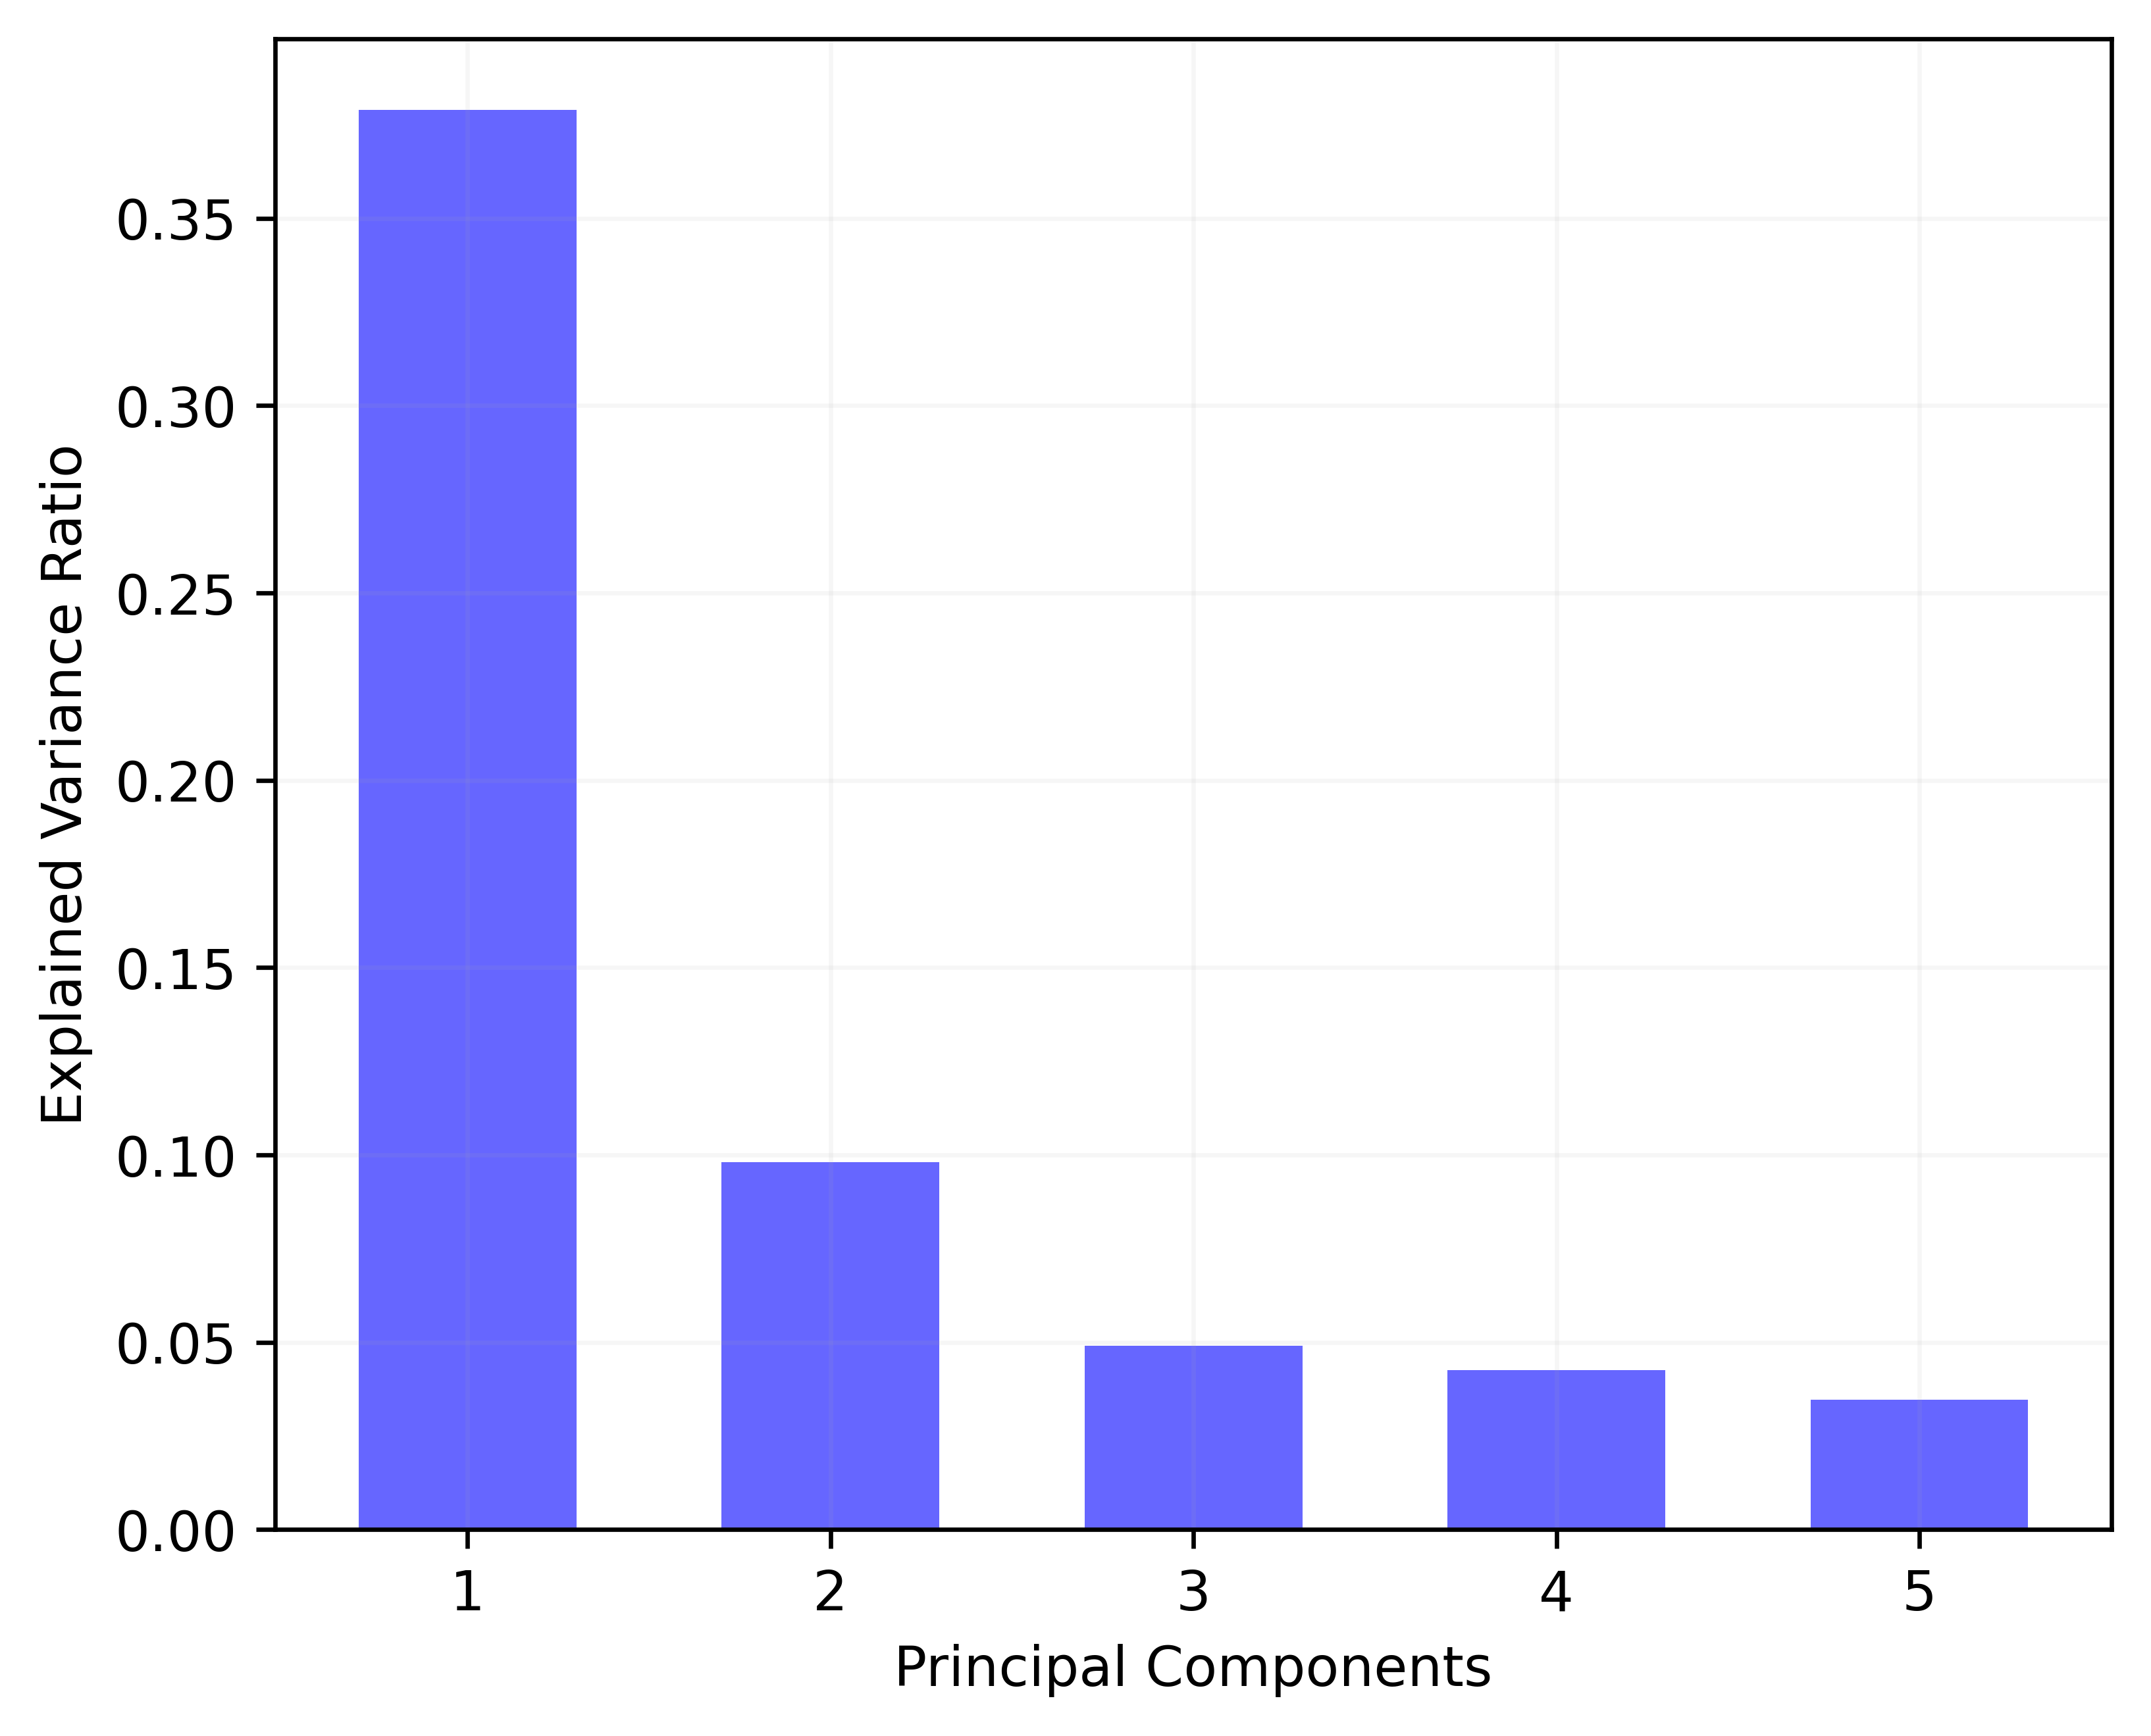

In [9]:
figs,axes = plt.subplots(1,1,figsize=(6,5))
axes.bar(np.linspace(1,N_comp,N_comp),VAR_pc,
                     color='b',width=0.6,alpha=0.6)
axes.set_xlabel("Principal Components")
axes.set_ylabel("Explained Variance Ratio")
axes.grid(alpha=0.1)

### 3-2) Plot the PC Time Series

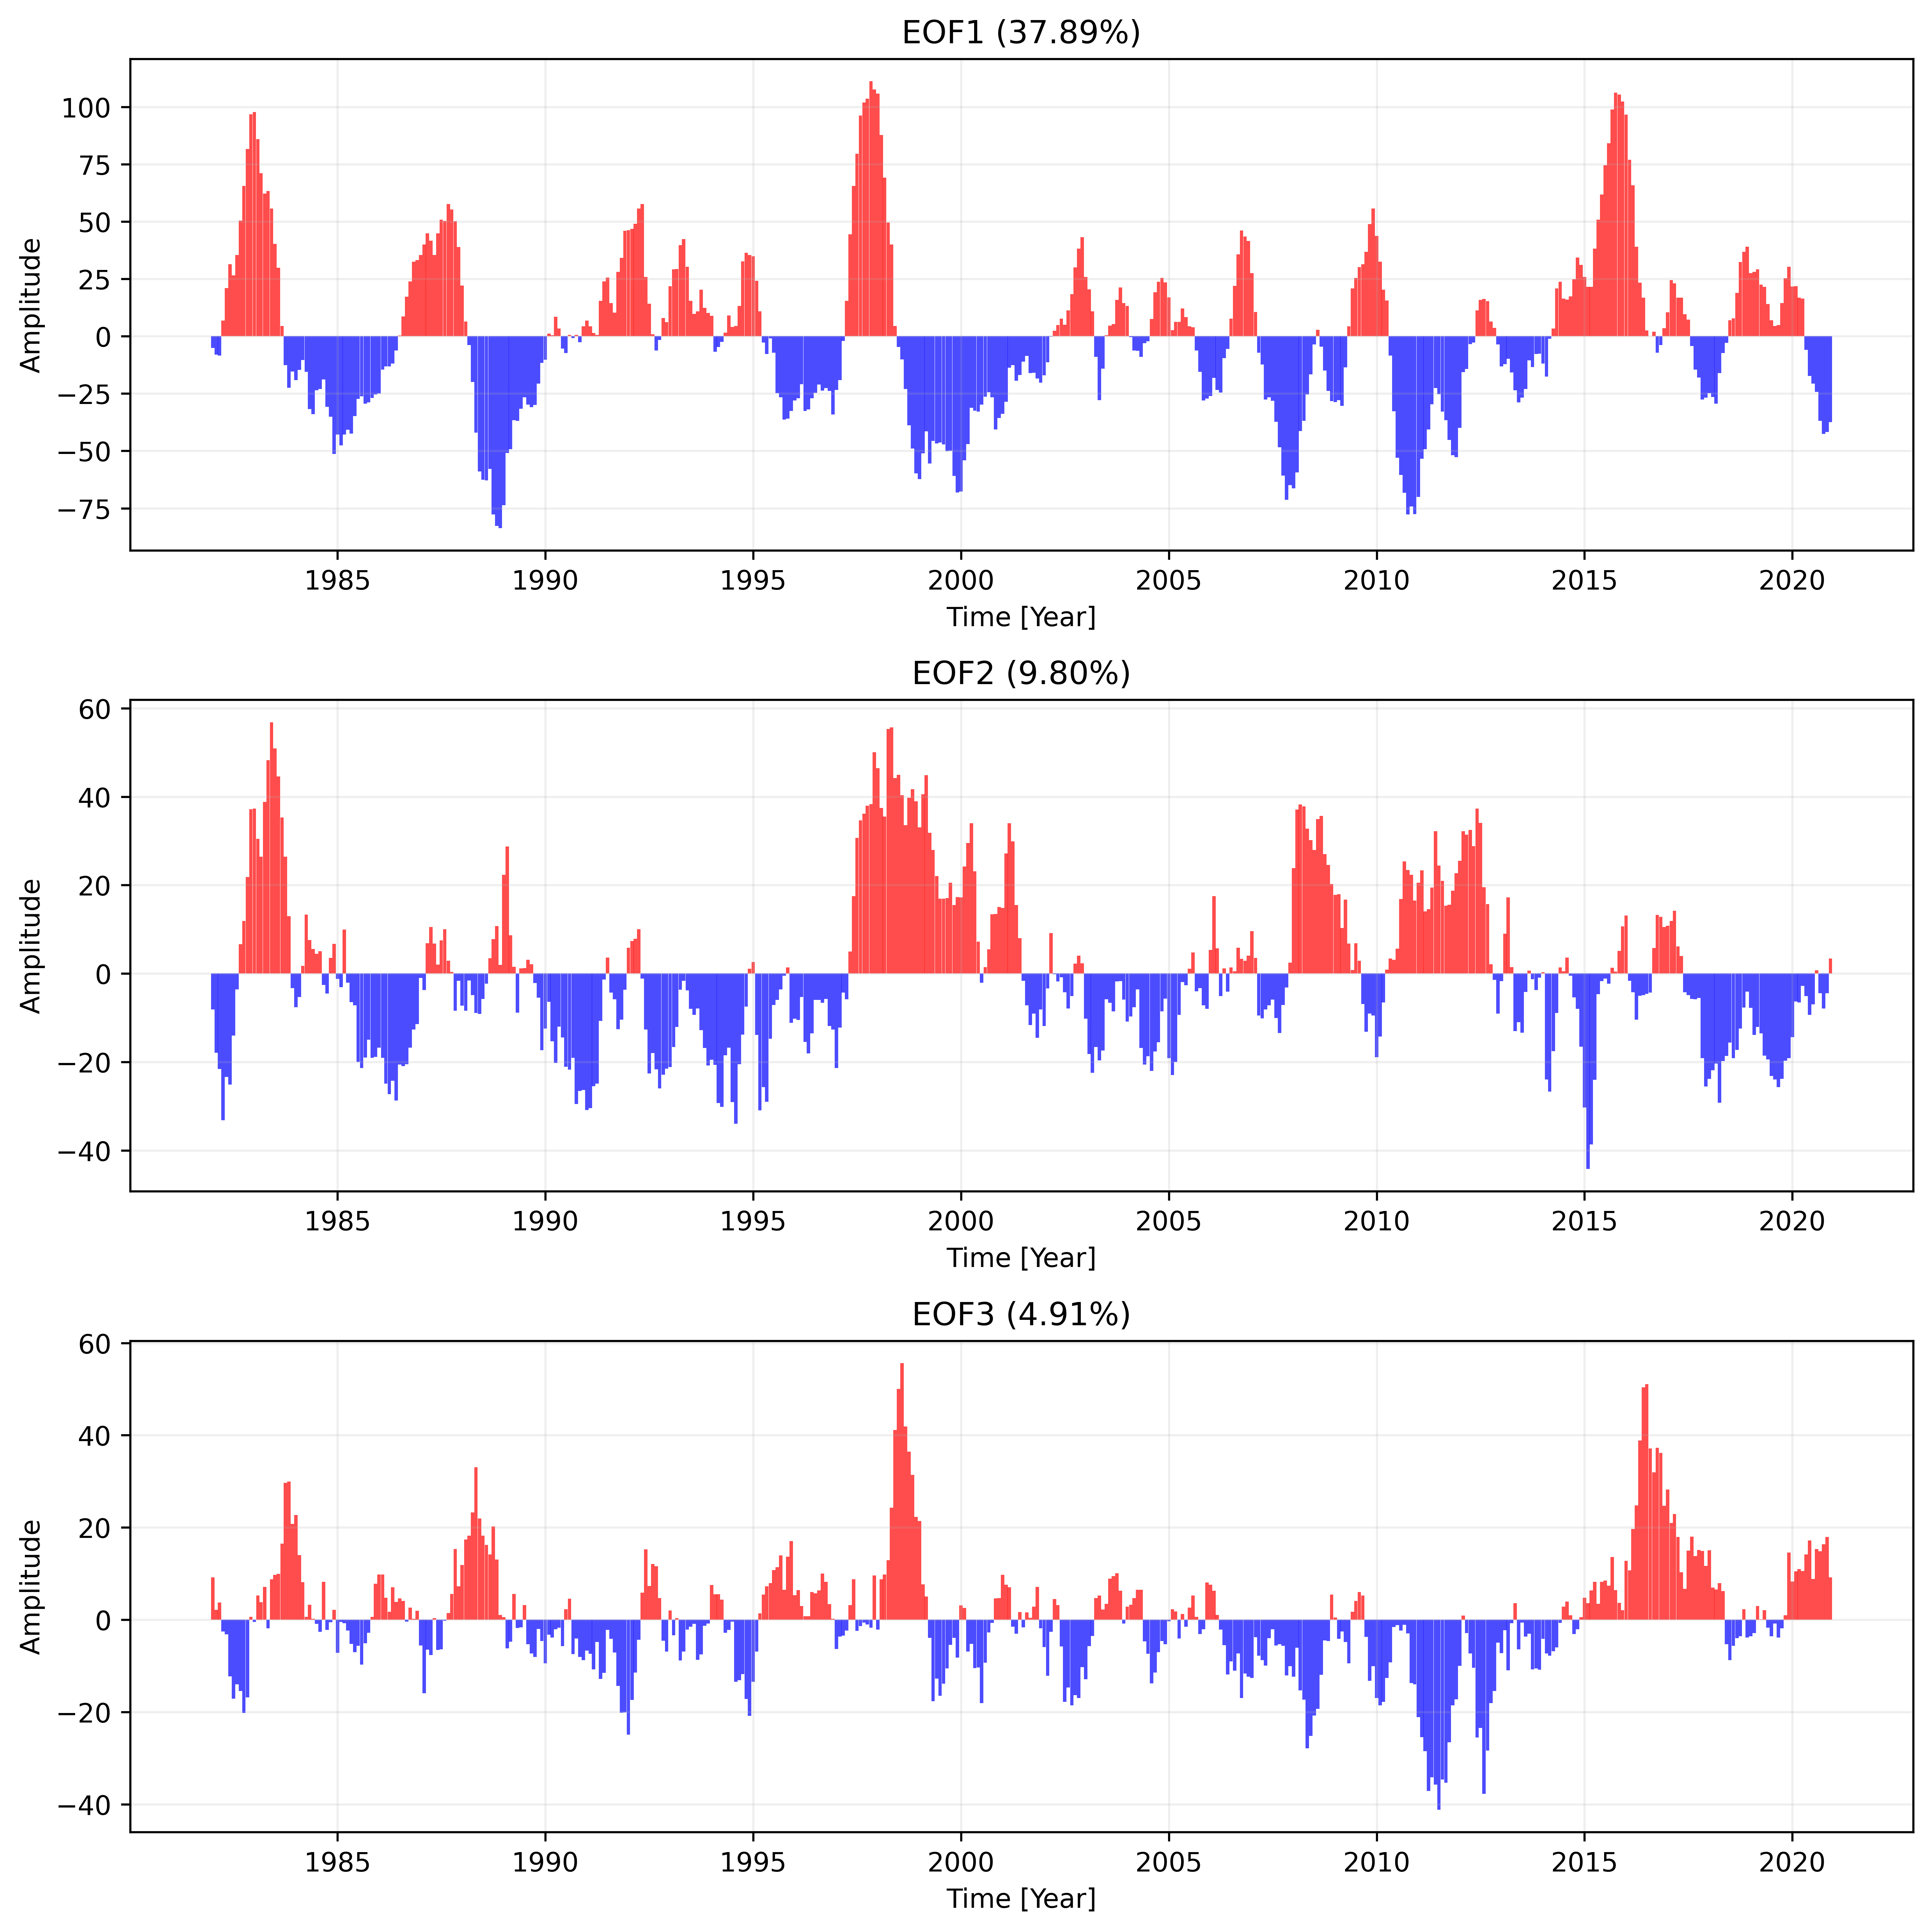

In [10]:
fig, axes = plt.subplots(3,1,figsize=(10,10),constrained_layout=True)

for ind_PC in range(3):
    ind_pos = np.where(TS_pc[:,ind_PC]>=0)[0]
    ind_neg = np.where(TS_pc[:,ind_PC]<0)[0]

    axes[ind_PC].bar(time[ind_year][ind_pos],TS_pc[ind_pos,ind_PC],
                     width=3e+1,color='r',alpha=0.7)
    axes[ind_PC].bar(time[ind_year][ind_neg],TS_pc[ind_neg,ind_PC],
                     width=3e+1,color='b',alpha=0.7) 
    
    axes[ind_PC].set_xlabel("Time [Year]")
    axes[ind_PC].set_ylabel("Amplitude")
    axes[ind_PC].set_title("EOF"+str(ind_PC+1)+
                           " ({:4.2f}%)".format(VAR_pc[ind_PC]*100))
    axes[ind_PC].grid(alpha=0.2)
    

### 3-3) Plot the PC Spatial Pattern for each PC

In [11]:
fig, axes = plt.subplots(3,1,figsize=(15,15),constrained_layout=True)

for ind_PC in range(3):
    sst_recon_1D    = np.empty([Ny*Nx])
    sst_recon_1D[:] = np.NaN

    sst_recon_1D[ind_nnan] = SP_pc[ind_PC,:]
    if (ind_PC==1): tmp_var = -sst_recon_1D.reshape(Ny,Nx)
    else:           tmp_var = sst_recon_1D.reshape(Ny,Nx)

    m, x, y = basemap_base('cyl',axes[ind_PC],lat.sel(lat=slice(latN,latS)),
                                              lon.sel(lon=slice(lonL,lonR)),
                                              latS,latN,lonL,lonR)

    vmin      = -2.5e-2 ; vmax  = 2.5e-2
    levels    = 10    ; level_boundaries = np.linspace(vmin,vmax,levels+1)

    contour_var = m.contourf(x,y,tmp_var,level_boundaries,cmap='RdBu_r',extend='both')
    axes[ind_PC].set_title("EOF"+str(ind_PC+1)+
                           " ({:4.2f}%)".format(VAR_pc[ind_PC]*100),fontsize=20)
    
cb = fig.colorbar(contour_var,ax=axes, shrink=0.75)
cb.set_ticks([-2e-2,-1e-2,0,1e-2,2e-2])
cb.ax.tick_params(labelsize=17.5)